In [109]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Fetching the MNIST Dataset

In [11]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')

# Converting the DataFrame to NumPy
X = mnist.data.to_numpy()
y = mnist.target.to_numpy()

# Reshaping to the size of an image
# X is the images
# y is the target values
X = X.reshape(70000, 28, 28).astype(np.float64)
y = y.flatten().astype(np.int64)

### Visualizing the Data

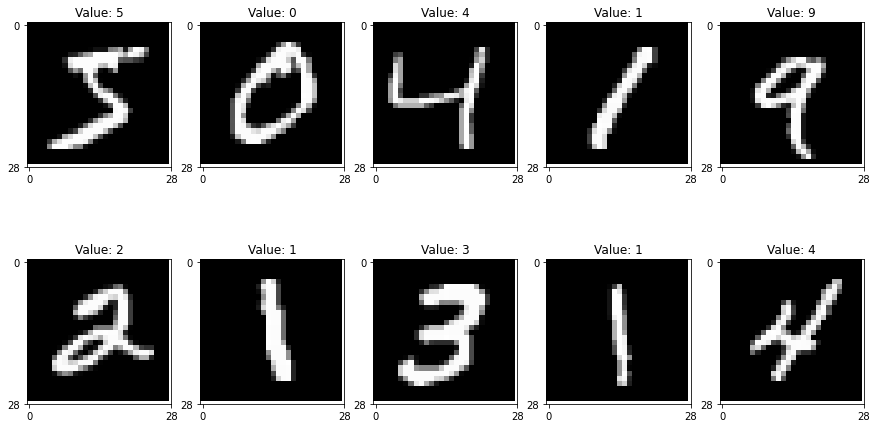

In [197]:
num_row = 2
num_col = 5
num = num_row * num_col

fig, axes = plt.subplots(num_row, num_col, figsize=(num_col*3,num_row*4))

for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(X[i], cmap='gray')
    ax.set_title('Value: {}'.format(y[i]))
    ax.set_xticks([0,28])
    ax.set_yticks([0,28])

plt.show()

### Adding augemented images to the data pool
- To add variability to the data so that the model recognizes handwritten digits in various positions

In [335]:
# Function to rotate data by a max random positive or negative degree
# Learn more about rotating matricies (images) at https://en.wikipedia.org/wiki/Rotation_matrix
def rotate_image(img,degrees):
    # convert to radians
    theta = np.deg2rad(degrees)

    #create rotation matrix with numpy array
    rot = np.transpose(np.array([[np.cos(theta),-np.sin(theta)],
                            [np.sin(theta),np.cos(theta)]]))
    
    # Center the pivot points
    pivot_x, pivot_y = (14, 14)
    
    aug_img = np.zeros(img.shape) 

    for ya in np.arange(28): # y-axis
        for xa in np.arange(28): # x-axis
            # Identifying new coordinates
            xy_vector = np.array([[xa-pivot_x],[ya-pivot_y]])
            
            rotate_mat = np.dot(rot,xy_vector).astype(np.int64).flatten()

            new_x = pivot_x + rotate_mat[0]
            new_y = pivot_y + rotate_mat[1]

            # Reassigning new coordinates to value
            # If the new coordinate is outside the dimentions of the image size (28,28), it is ignored
            if (0<=new_x<=27) and (0<=new_y<=27): 
                aug_img[new_y,new_x] = img[ya,xa]

    return aug_img

# Function to augment training data
# This is not vectorized. Try vectorizing it for fun!
def add_augmented_data(X, Y):

    images_list = []
    labels_list = []

    for x, y in zip(X, Y):

        # Keep original data
        images_list.append(np.reshape(x, 784))
        labels_list.append(y)
    
        image = x

        for i in range(4):
            # Rotate the image with random degree
            angle = np.random.randint(-15,15,1)
            new_img = rotate_image(image, angle)

            # Shift the image with random distance
            shift = np.random.randint(-2, 2, 1).__int__()
            new_img_ = np.roll(new_img,shift, axis=1)

            # Add new training data
            images_list.append(np.reshape(new_img_, 784))
            labels_list.append(y)

    # Concatenating images and labels
    images_list = np.array(images_list)
    labels_list = np.matrix(labels_list).T
    expanded_train_total_data = np.concatenate(
        (
            images_list,
            labels_list
        ),
        axis=1)

    return expanded_train_total_data


In [343]:
# Running this function takes a while. Try vectorizing it. If not, load the data from the saved numpy file down below!
aug_data = add_augmented_data(X, y)

# Load NumPy Data. The output of the function above
# aug_data = np.load('data/data.npy')

In [344]:
aug_data.shape

(350000, 785)

### Visualizing the Augemented Data

In [345]:
# converting back to array from matrix and extraction the correct data
aug_X, aug_y = np.array(aug_data[:,:784]), np.array(aug_data[:,784])

aug_X = aug_X.reshape(-1, 28, 28, 1) # the reshape 1 at the end tells our tensorflow model that this is a black and white image. The model will not run without this
aug_y = aug_y.flatten().astype(np.int64)

In [346]:
aug_X.shape

(350000, 28, 28, 1)

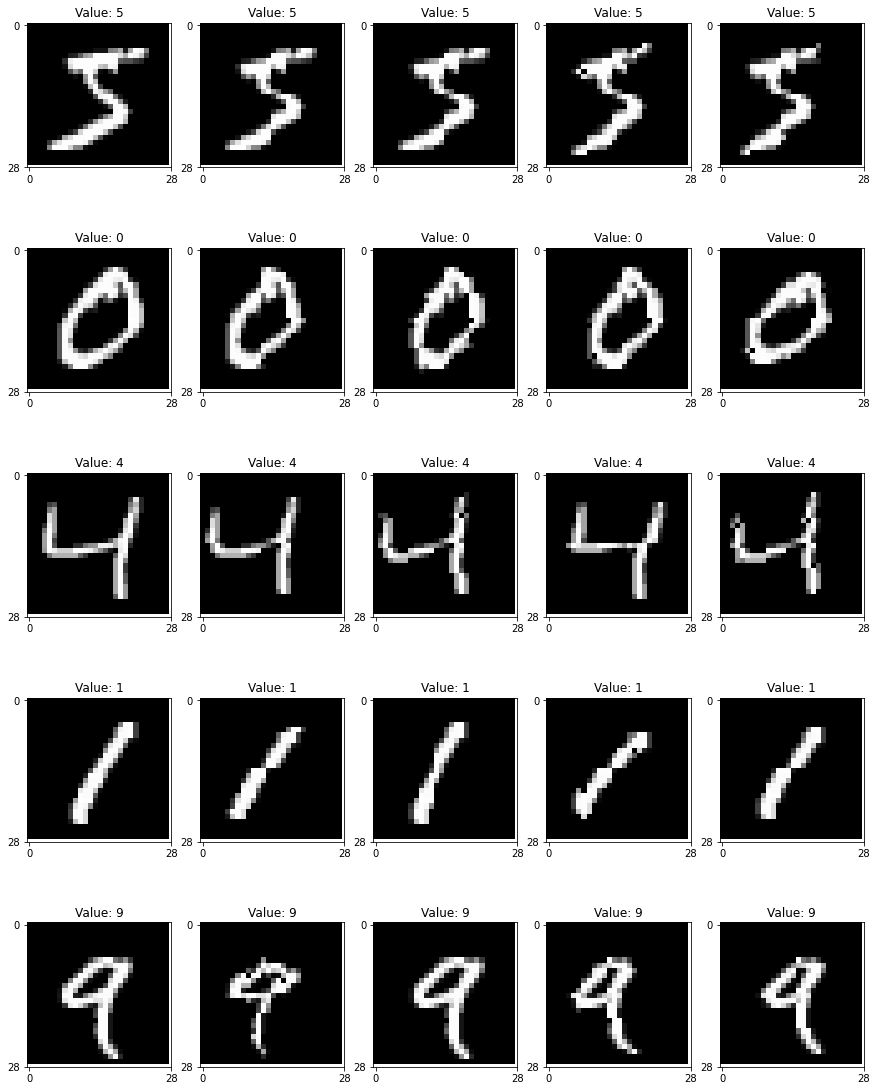

In [347]:
num_row = 5
num_col = 5
num = num_row * num_col

fig, axes = plt.subplots(num_row, num_col, figsize=(num_col*3,num_row*4))

for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(aug_X[i], cmap='gray')
    ax.set_title('Value: {}'.format(aug_y[i]))
    ax.set_xticks([0,28])
    ax.set_yticks([0,28])

plt.show()

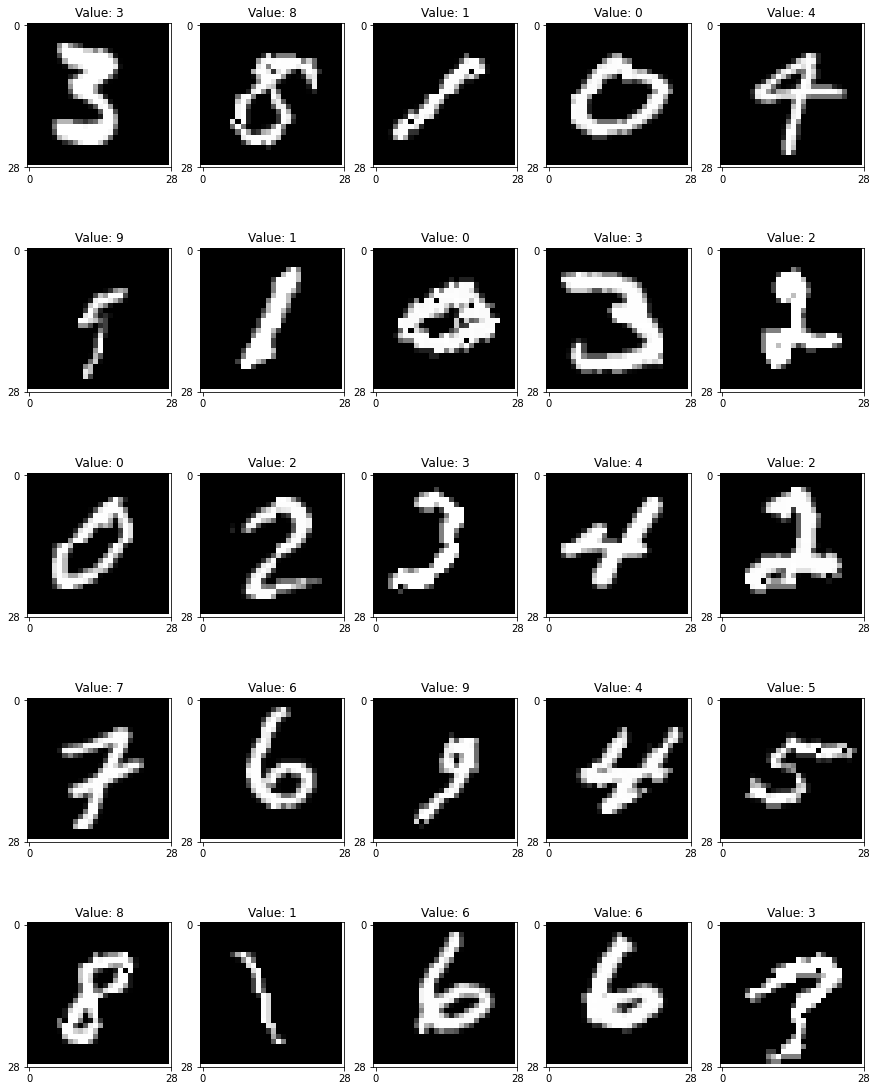

In [350]:
# Randomize the order of training samples for improved model performence. 'shuffle' is an inplace function
np.random.shuffle(aug_data)

# converting back to array from matrix and extraction the correct data
aug_X, aug_y = np.array(aug_data[:,:784]), np.array(aug_data[:,784])

aug_X = aug_X.reshape(-1, 28, 28, 1) # the reshape 1 at the end tells our tensorflow model that this is a black and white image. The model will not run without this
aug_y = aug_y.flatten().astype(np.int64)

# Again visualizing the data
num_row = 5
num_col = 5
num = num_row * num_col

fig, axes = plt.subplots(num_row, num_col, figsize=(num_col*3,num_row*4))

for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(aug_X[i], cmap='gray')
    ax.set_title('Value: {}'.format(aug_y[i]))
    ax.set_xticks([0,28])
    ax.set_yticks([0,28])

plt.show()

### Defining the training and testing samples

I will not be converting the target variables into the one-hot-encoded form as I will be using the "sparse_categorical_crossentropy" instead of the "categorical_crossentropy" loss function when compiling the model. 
- "categorical_crossentropy" requires the one-hot-encoding and produces a probability for each index in the encoded array
- "sparse_categorical_crossentropy" is the same loss function as above but instead of classifying to the encoded arrays above, it classifies them to the integers themselves.
    - More info at https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy

In [351]:
train_samples = 50000 * 5
test_samples = aug_X.shape[0] - train_samples

# In order to train the model properly, you need to one-hot-encode the target variable (in this case "y"). 
# But tensorflow has a trick where you can use the loss function "sparse_categorical_crossentropy" to bypass this step. As such, I won't one-hot-encode the target
X_train, y_train = aug_X[:train_samples], aug_y[:train_samples]
X_test, y_test = aug_X[train_samples:], aug_y[train_samples:]

### Creating and running the model

In [352]:
# Model
def make_model():
    model = Sequential()

    model.add(
        Conv2D(32, (5, 5), activation='relu', input_shape=( 28, 28, 1))
    )
    model.add(
        MaxPooling2D((2, 2))
    )
    model.add(
        Conv2D(64, (5, 5), activation='relu')
    )
    model.add(
        MaxPooling2D((2, 2))
    )
    model.add(
        Flatten()
    )
    model.add(
        Dense(1024, activation='relu')
    )
    model.add(
        Dense(10, activation="softmax")
    )

    model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [354]:
model = make_model()
history = model.fit(X_train, y_train, epochs=50, batch_size=256, validation_data=(X_test, y_test), verbose=0)

### Optimizing the model

In [355]:
loss = history.history['loss']
accuracy = history.history['accuracy']
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']

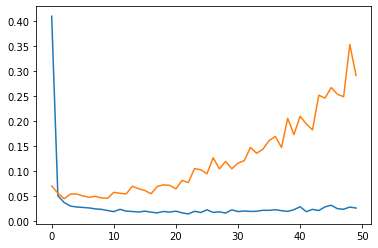

In [356]:
plt.plot(loss)
plt.plot(validation_loss)
plt.show()

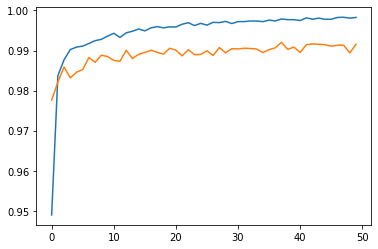

In [357]:
plt.plot(accuracy)
plt.plot(validation_accuracy)
plt.show()

### Retrain the model except with fewer epochs
- The model seems to reach max performance after 10 epochs

In [366]:
model = make_model()
history = model.fit(X_train, y_train, epochs=10, batch_size=256, validation_data=(X_test, y_test), verbose=0)

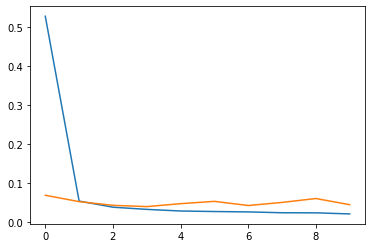

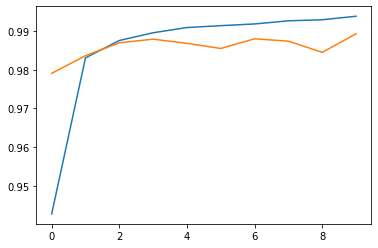

In [367]:
loss = history.history['loss']
accuracy = history.history['accuracy']
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']

plt.plot(loss)
plt.plot(validation_loss)
plt.show()

plt.plot(accuracy)
plt.plot(validation_accuracy)
plt.show()

Notice how the predictions of the model are one-hot-encoded even though I did not encode them when preparing the data

In [360]:
y_predict = model.predict(X_test)
print(y_predict[0])

[8.9133777e-11 1.4618558e-08 1.0024654e-05 9.9991000e-01 2.4662122e-10
 4.4319265e-07 1.2944847e-09 1.1685610e-07 7.7446683e-05 1.9299939e-06]


Converting the predicted arrays into integers

In [361]:
y_predict = y_predict.argmax(axis=1)
print(y_predict)

[3 7 1 ... 5 9 4]


In [362]:
from sklearn.metrics import confusion_matrix


matx = confusion_matrix(y_pred=y_predict, y_true=y_test)
matx_df = pd.DataFrame(matx, columns=[0,1,2,3,4,5,6,7,8,9])

In [363]:
matx_df

,0,1,2,3,4,5,6,7,8,9
0,9701,3,3,9,1,2,13,0,6,2
1,1,11216,16,7,9,0,6,37,4,3
2,10,14,9890,23,3,0,1,39,5,6
3,2,2,7,10096,0,28,0,10,16,16
4,3,8,6,1,9562,0,22,24,3,59
5,5,3,2,57,1,8917,26,7,23,8
6,11,9,1,4,7,12,9752,0,20,0
7,9,15,11,10,10,0,0,10415,3,29
8,3,13,21,29,13,21,13,3,9633,25
9,9,5,0,14,83,18,4,42,11,9778


### Retraining and saving the final model with all the data and 10 epochs

In [368]:
final_model = make_model()
history = final_model.fit(aug_X, aug_y, epochs=10, batch_size=256, verbose=0)

In [369]:
# Save Model
path = "./models/final_model.h5"

final_model.save(path)